In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [ ]:
df = pd.read_csv('/content/blood.csv')  # Use the exact filename you uploaded
print("Dataset preview:")
print(df.head())


Dataset preview:
   Recency  Frequency  Monetary  Time  Class
0        2         50     12500    99      1
1        0         13      3250    28      1
2        1         17      4000    36      1
3        2         20      5000    45      1
4        1         24      6000    77      0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB
None

Class distribution:
Class
0    570
1    178
Name: count, dtype: int64


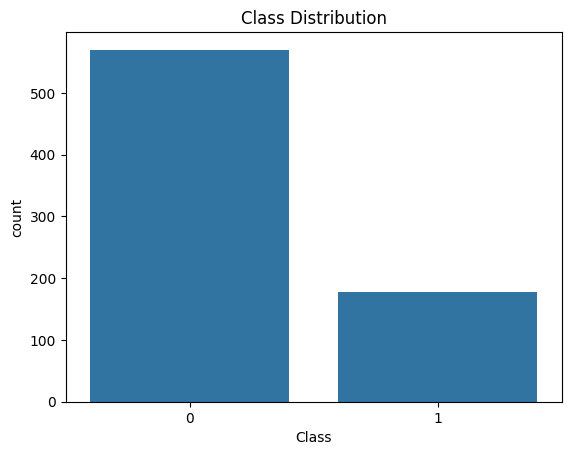

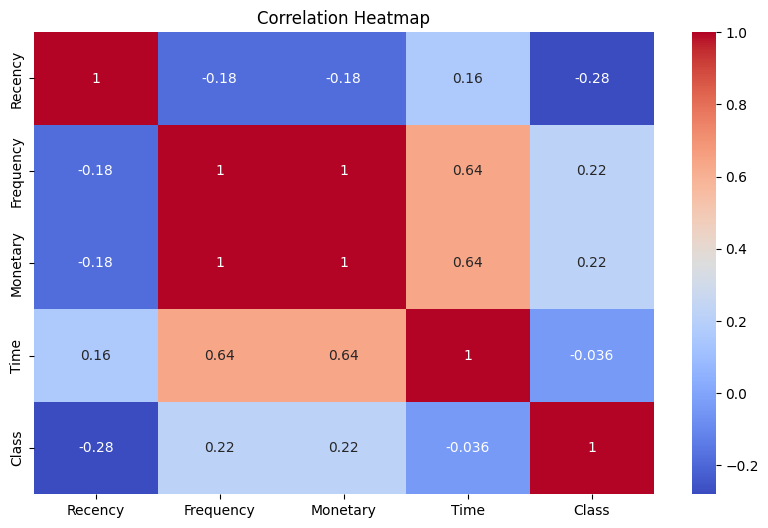

In [ ]:
print("\nDataset Info:")
print(df.info())

print("\nClass distribution:")
print(df['Class'].value_counts())

# Visualize class distribution
sns.countplot(data=df, x='Class')
plt.title('Class Distribution')
plt.show()

# Correlation heatmap (numerical only)
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

# Identify column types
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipelines
num_pipeline = Pipeline([('scaler', StandardScaler())])
cat_pipeline = Pipeline([('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True)
}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {np.mean(scores):.4f}")



Random Forest CV Accuracy: 0.7559
Logistic Regression CV Accuracy: 0.7776
SVM CV Accuracy: 0.7826


In [ ]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
final_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Recency', 'Frequency',
                                                   'Monetary', 'Time']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier', RandomForestClassifier(random_state=42))])


Confusion Matrix:
[[100  13]
 [ 28   9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       113
           1       0.41      0.24      0.31        37

    accuracy                           0.73       150
   macro avg       0.60      0.56      0.57       150
weighted avg       0.69      0.73      0.70       150



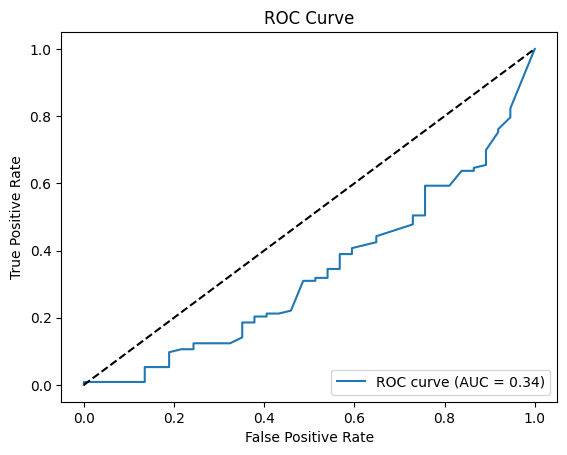

In [ ]:
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1], pos_label=y.unique()[1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
random_patient = X.sample(1, random_state=42)
print("\nRandom Patient Data:")
print(random_patient)

predicted_class = final_pipeline.predict(random_patient)
print("Predicted Class:", predicted_class[0])

# Optional: Recommendation Mapping
recommendation_map = {
    0: "No action needed",
    1: "Lifestyle changes",
    2: "Routine monitoring required",
    3: "Immediate medical consultation"
}

recommendation = recommendation_map.get(predicted_class[0], "Unknown")
print("Personalized Recommendation:", recommendation)


Random Patient Data:
     Recency  Frequency  Monetary  Time
580        2          1       250     2
Predicted Class: 0
Personalized Recommendation: No action needed
